<Body>   
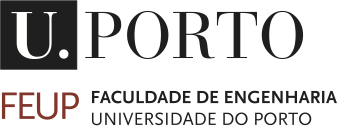   
<h1> <b>Computer Vision 2022/2023 </b> </h1>
<p><b>João Carlos N. Bittencourt </b> (joaocarlos@ufrb.edu.br)</p>
<p>PhD Student</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# A Remote Sensing Fire Risk Assessment Using Convolutional Neural Networks

## Introduction
This script is used to train a convolutional neural network (CNN) to predict fire risk from satellite images.



In [2]:
# include libraries
import sys
sys.path.append('./libs')
import torch
import torch.nn as nn
import torch.nn.functional as F
import libs.setup as su
import importlib


# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


## Dataset
The dataset is composed of 7 classes: very low, low, moderate, high, very high, non-burnable and water. The images are 320x320 pixels and are stored in the `FireRisk-Dataset` folder. The dataset is divided into training and test sets. The training set has 70331 images and the test set has 21541 images.

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
from libs.dataset import FireRiskDataset

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((320, 320)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAdjustSharpness(2, 0.9),
        transforms.RandomVerticalFlip(),
        transforms.Normalize(
            mean=(0.3065, 0.3675, 0.3278), std=(0.0605, 0.0840, 0.0924)
        ),
    ]
)

transform_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((320, 320)),
        transforms.Normalize(
            mean=(0.3065, 0.3675, 0.3278), std=(0.0605, 0.0840, 0.0924)
        ),
    ]
)

classes = ["High", "Moderate", "Low", "Non-burnable", "Water"]

label_dict = {
    "High": 0,
    "Moderate": 1,
    "Low": 2,
    "Non-burnable": 3,
    "Water": 4,
}

# Setup training dataset and loader
train_dataset = FireRiskDataset(
    root_dir="./FireRisk-Dataset/FireRiskV2/train/",
    transform=transform,
    sample_size=round(su.train_samples),
    label_dict=label_dict,
)

# Setup validation dataset and loader
val_dataset = FireRiskDataset(
    root_dir="./FireRisk-Dataset/FireRiskV2/val/",
    transform=transform_val,
    sample_size=su.sample_size,
    label_dict=label_dict,
)

train_loader = DataLoader(
    train_dataset, batch_size=su.batch_size, shuffle=True, num_workers=su.num_workers
)

val_loader = DataLoader(
    val_dataset, batch_size=su.batch_size, shuffle=False, num_workers=su.num_workers
)

In [4]:
dataset = FireRiskDataset(
    root_dir="./FireRisk-Dataset/FireRiskV2/train/",
    label_dict=label_dict,
    transform=transforms.ToTensor(),
)
loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=2)

mean = 0.0
std = 0.0
nb_samples = 0

for data in loader:
    data = data[0]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(mean, std)

tensor([0.3065, 0.3675, 0.3278]) tensor([0.0605, 0.0840, 0.0924])


/home/joaocarlos/.cache/matplotlib


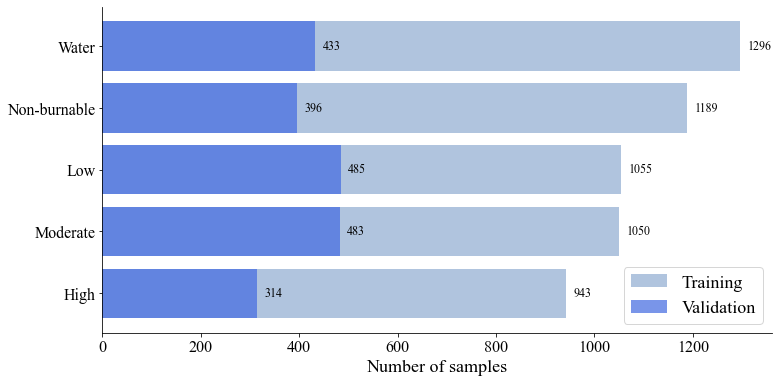

Training dataset size: 5533
Validations dataset size: 2111


<Figure size 432x288 with 0 Axes>

In [5]:
# Plot a graph with the number of samples per class
import matplotlib.pyplot as plt
import matplotlib as mpl

print(mpl.get_cachedir())

# Set global font to Arial
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18  # You can also set the global font size here

plt.figure(figsize=(12, 6))

# Plot training data
train_counts = [train_dataset.labels.count(i) for i in range(len(classes))]
plt.barh(classes, train_counts, label='Training', color='lightsteelblue')

# Plot validation data
val_counts = [val_dataset.labels.count(i) for i in range(len(classes))]
plt.barh(classes, val_counts, label='Validation', alpha=0.7, color='royalblue')

# Labels and title
plt.xlabel("Number of samples")
# plt.ylabel("Class")
# plt.title("Number of samples per class")
plt.legend()

# Font sizes for ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add total number of samples after the bar
margin = 15
for index, value in enumerate(train_counts):
    plt.text(value + margin, index, str(value), va='center', ha='left', fontsize=12, color='black')
for index, value in enumerate(val_counts):
    plt.text(value + margin, index, str(value), va='center', ha='left', fontsize=12, color='black')

plt.show()

plt.savefig('prometheus_dataset.png', dpi=300)

# Print dataset sizes
print("Training dataset size:", len(train_dataset))
print("Validations dataset size:", len(val_dataset))

# Defining the CNN Model
The CNN model is defined using the timm library. For this experiment we will use the inception_resnet_v2 model with the following modifications:
- The output layer is modified to have 7 classes
- The model is trained using the Adam optimizer with a learning rate of 0.000125 
- The model is trained using the categorical crossentropy loss function


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # First convolutional layer with BatchNorm and increased filter size
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional layer with BatchNorm
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        # self.dropout1 = nn.Dropout2d(p=0.2)

        # Third and fourth convolutional layers with BatchNorm
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(p=0.3)

        # Max Pooling and Dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(p=0.5)

        # Fully connected layers
        # Adjusted for the output size of the final conv layer
        self.fc1 = nn.Linear(
            128 * 10 * 10, 256
        )  # Adjusted dimensions according to the final feature map size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)  # Adjusted for 5 classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        # x = self.dropout1(x)  # Apply first dropout after second pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout2(x)
        x = self.pool(x)  # Apply second dropout before final pooling
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch
        x = self.dropout3(F.relu(self.fc1(x)))  # Apply third dropout before first fully connected layer
        x = F.relu(self.fc2(x))
        output = self.fc3(
            x
        )  # No activation here: make sure classification with CrossEntropyLoss
        return output


# Instantiate a neural network model
model = Network()

optimizer = torch.optim.SGD(
    model.parameters(), lr=su.learning_rate, weight_decay=su.weight_decay
)
criterion = nn.CrossEntropyLoss(label_smoothing=su.smoothing_factor)

In [20]:
# Print model architecture
print(model.modules)

<bound method Module.modules of Network(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=12800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128,

## Training the Model

In [28]:
import libs.model_utils as mu

if __name__ == "__main__":

    # Build our model
    (
        best_loss,
        best_accuracy,
        best_epoch,
        train_acc_list,
        train_loss_list,
        val_acc_list,
        val_loss_list,
    ) = mu.train_and_eval(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        device=device,
        start_epoch=0,
        num_epochs=su.num_epochs+40,
        early_stop=True,
        patience=su.patience,
        path_model=str("./models/MyCNNModel/Prometheus_MyCNNModel_"),
        verbatim=True,
    )
    print('Finished Training')

/home/joaocarlos/.local/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1 / 120]: Train Loss=1.5790528338079508, Train Accu=0.30941529568697196, Validation Loss=1.5412529580520862, Validation Accu=0.37585227272727273
Validation loss decreased (inf --> 1.541253).  Saving model ...
Epoch [2 / 120]: Train Loss=1.5094277776045606, Train Accu=0.41034904401956424, Validation Loss=1.4549028819257563, Validation Accu=0.45397727272727273
Validation loss decreased (1.541253 --> 1.454903).  Saving model ...
Epoch [3 / 120]: Train Loss=1.4252318540060451, Train Accu=0.4790740329035127, Validation Loss=1.3555840461543112, Validation Accu=0.5600063131313131
Validation loss decreased (1.454903 --> 1.355584).  Saving model ...
Epoch [4 / 120]: Train Loss=1.3500570506718808, Train Accu=0.5144647621164962, Validation Loss=1.2705862269257053, Validation Accu=0.6101641414141414
Validation loss decreased (1.355584 --> 1.270586).  Saving model ...
Epoch [5 / 120]: Train Loss=1.281529645010226, Train Accu=0.5499110715873722, Validation Loss=1.1960204663601788, Validation 

Best loss: 0.9165152351964604
Best accuracy: 0.7162878787878788
Best epoch: 117


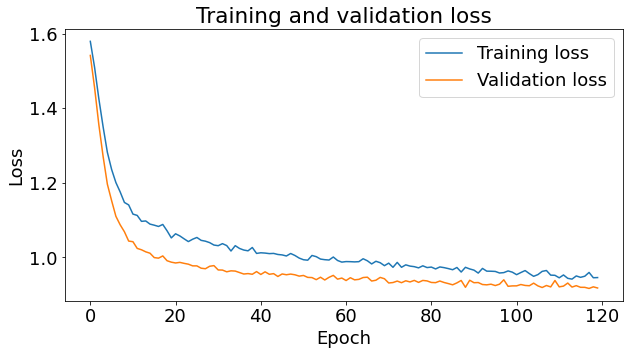

In [33]:
# Display the best results
print("Best loss:", best_loss)
print("Best accuracy:", best_accuracy)
print("Best epoch:", best_epoch)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="Training loss")
plt.plot(val_loss_list, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [21]:
# Load the best model
import libs.model_utils as mu

# Load the model we just created
model = model.to(device)

# Get best model path
best_model_path = ("./models/MyCNNModel/Prometheus_MyCNNModel_checkpoint.pth")

model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

# Model Evaluation

In [22]:
true_labels, predicted_labels = mu.evaluate_model(model, val_loader, device, criterion)

/home/joaocarlos/.local/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy on validation set: 71.62482235907153%


In [23]:
# Implement precision, recall and F1-score assessment
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=classes)

print(report)

              precision    recall  f1-score   support

        High       0.71      0.61      0.66       314
    Moderate       0.61      0.71      0.66       483
         Low       0.73      0.69      0.71       485
Non-burnable       0.66      0.74      0.70       396
       Water       0.93      0.80      0.86       433

    accuracy                           0.72      2111
   macro avg       0.73      0.71      0.72      2111
weighted avg       0.73      0.72      0.72      2111



Predicted class: Moderate
File name: 28626291_2_-120.722748819531_41.878868960752.png


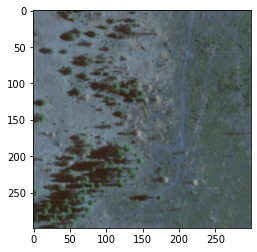

In [ ]:
mu.predict_image_class(class_name="Moderate", dataset=val_dataset, model=model, device=device, transform=transform)

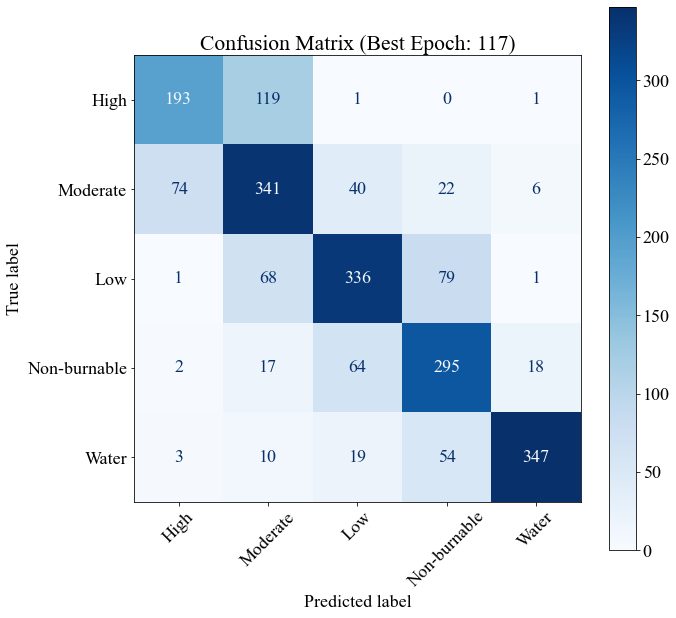

In [24]:
from importlib import reload
import libs.model_utils as mu
reload(mu)
mu.plot_confusion_matrix(true_labels, predicted_labels, classes, 117)